# Get Crew (Actors and Director) Power

- A crew's **imdb power** = mean(imdb_score for the crew's movies)
- A crew's **box office (bo) power** = mean(bo_gross_to_budget_ratio for the crew's movies)
- Note: to aviod data leakage, I will calculate the crews' power for each year from 2013 to 2019. 

In [1]:
import collections
from time import time
from multiprocessing import Pool, cpu_count
import tqdm  # show multi-processing progress bar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import calendar

# for auto reload a module after editing.
%load_ext autoreload
%autoreload 2

In [2]:
def id_to_year(tt_id, df):
    """
    Given a movie's tt_id, return the year this movie.
    """
    return df[df['tt_id'] == tt_id]['Year'].iloc[0]


def id_to_bo(tt_id, df):
    """
    Given a movie's tt_id, return the gross box office to budget ratio of this movie.
    """
    return df[df['tt_id'] == tt_id]['gross_to_budget'].iloc[0]


def id_to_score(tt_id, df):
    """
    Given a movie's tt_id, return the imdb_score of this movie.
    """
    return df[df['tt_id'] == tt_id]['imdb_score'].iloc[0]

## 1. Get directors' imdb power, bo power, and movie count

In [3]:
file = "./data/movie_list/metadata_2000-2019.csv"
df = pd.read_csv(file)
with open("./data/movie_list/_excluded_movies.txt", "r") as f:
    excluded_movies = f.read().split('\n')
df = df[~df['Title'].isin(excluded_movies)]
df = df.reset_index(drop=True)
df.loc[:, 'gross_to_budget'] = df.loc[:, 'bo_gross'] / df.loc[:, 'budget']

In [4]:
df.head(5)

,Year,Rank,Title,tt_id,rl_id,release_date,company,mpaa,genres,runtime,director,actors,budget,bo_opening,bo_gross,imdb_score,gross_to_budget
0,2000,1,How the Grinch Stole Christmas,tt0170016,rl3059189249,2000-11-17,Universal Pictures,PG,"Comedy,Family,Fantasy",104,Ron Howard,"Jim Carrey,Taylor Momsen,Kelley,Jeffrey Tambor",123.0,55.082330,260.044825,6.2,2.114186
1,2000,2,Mission: Impossible II,tt0120755,rl1600292353,2000-05-24,Paramount Pictures,PG-13,"Action,Adventure,Thriller",123,John Woo,"Tom Cruise,Dougray Scott,Thandie Newton,Ving R...",125.0,57.845297,215.409889,6.1,1.723279
2,2000,3,Gladiator,tt0172495,rl2136245761,2000-05-05,DreamWorks Distribution,R,"Action,Adventure,Drama",155,Ridley Scott,"Russell Crowe,Joaquin Phoenix,Connie Nielsen,O...",103.0,34.819017,187.705427,8.5,1.822383
3,2000,4,The Perfect Storm,tt0177971,rl661161473,2000-06-30,Warner Bros.,PG-13,"Action,Adventure,Drama,Thriller",130,Wolfgang Petersen,"George Clooney,Mark Wahlberg,John C. Reilly,Di...",140.0,41.325042,182.618434,6.4,1.304417
4,2000,5,Meet the Parents,tt0212338,rl677545473,2000-10-06,Universal Pictures,PG-13,"Comedy,Romance",108,Jay Roach,"Ben Stiller,Robert De Niro,Teri Polo,Blythe Da...",55.0,28.623300,166.244045,7.0,3.022619


In [5]:
director_to_movies = {}
for i in range(df.shape[0]):
    director = df.loc[i, 'director']
    tt_id = df.loc[i, 'tt_id']
    movies = director_to_movies.get(director, [])
    movies.append(tt_id)
    director_to_movies[director] = movies
director_to_movies = {k: v for k, v in sorted(director_to_movies.items(), key=lambda x: len(x[1]), reverse=True)}

In [6]:
# Print directors who direct most movies:
for i in range(10):
    director = list(director_to_movies.keys())[i]
    movies = director_to_movies[director]
    print("{}: {}".format(director, movies))

Tyler Perry: ['tt0455612', 'tt0906108', 'tt0778661', 'tt1385912', 'tt1391137', 'tt1787759', 'tt2215285', 'tt2609758', 'tt2465140', 'tt5325452', 'tt6217804', 'tt6063050', 'tt8097306']
Ridley Scott: ['tt0172495', 'tt0212985', 'tt0325805', 'tt0320661', 'tt0765429', 'tt0758774', 'tt0955308', 'tt1446714', 'tt1528100', 'tt3659388', 'tt2316204', 'tt5294550']
Steven Spielberg: ['tt0212720', 'tt0181689', 'tt0264464', 'tt0362227', 'tt0407304', 'tt0367882', 'tt0983193', 'tt0443272', 'tt3682448', 'tt3691740', 'tt1677720']
Shawn Levy: ['tt0265298', 'tt0305711', 'tt0349205', 'tt0477347', 'tt0383216', 'tt1078912', 'tt1279935', 'tt0433035', 'tt2234155', 'tt2692250', 'tt1371150']
M. Night Shyamalan: ['tt0217869', 'tt0286106', 'tt0368447', 'tt0452637', 'tt0949731', 'tt0938283', 'tt1815862', 'tt3567288', 'tt4972582', 'tt6823368']
Michael Bay: ['tt0213149', 'tt0172156', 'tt0399201', 'tt0418279', 'tt1055369', 'tt1399103', 'tt1980209', 'tt2109248', 'tt4172430', 'tt3371366']
Robert Zemeckis: ['tt0161081', 't

In [7]:
# Get directors' movie count:
dir_cnt_df = pd.DataFrame(columns=range(2013, 2022))
for director in director_to_movies:
    movies = director_to_movies[director]
    for year in range(2013, 2022):
        count = 0
        for m in movies:
            if id_to_year(m, df) >= year:
                continue
            count += 1
        dir_cnt_df.loc[director, year] = count
dir_cnt_df.to_csv("./data/directors_movie_count.csv")

In [8]:
dir_cnt_df

,2013,2014,2015,2016,2017,2018,2019,2020,2021
Tyler Perry,7,8,9,9,10,11,13,13,13
Ridley Scott,8,8,9,10,10,12,12,12,12
Steven Spielberg,8,8,8,9,10,10,11,11,11
Shawn Levy,8,9,11,11,11,11,11,11,11
M. Night Shyamalan,6,7,7,8,8,9,9,10,10
...,...,...,...,...,...,...,...,...,...
Nisha Ganatra,0,0,0,0,0,0,0,1,1
Nicholas McCarthy,0,0,0,0,0,0,0,1,1
Zara Hayes,0,0,0,0,0,0,0,1,1
Gurinder Chadha,0,0,0,0,0,0,0,1,1


In [9]:
# Get directors' imdb power:
dir_imdb_df = pd.DataFrame(columns=range(2013, 2022))
for director in director_to_movies:
    movies = director_to_movies[director]
    for year in range(2013, 2022):
        powers = []
        for m in movies:
            if id_to_year(m, df) >= year:
                continue
            powers.append(id_to_score(m, df))
        dir_imdb_df.loc[director, year] = np.nanmean(powers)
dir_imdb_df.to_csv("./data/directors_imdb_power.csv")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [10]:
dir_imdb_df

,2013,2014,2015,2016,2017,2018,2019,2020,2021
Tyler Perry,5.08571,5.05,5.07778,5.07778,5.03,4.91818,4.97692,4.97692,4.97692
Ridley Scott,7.2875,7.2875,7.14444,7.23,7.23,7.125,7.125,7.125,7.125
Steven Spielberg,7.1875,7.1875,7.1875,7.23333,7.15,7.15,7.18182,7.18182,7.18182
Shawn Levy,6.0375,6.06667,6.12727,6.12727,6.12727,6.12727,6.12727,6.12727,6.12727
M. Night Shyamalan,5.85,5.7,5.7,5.7625,5.7625,5.93333,5.93333,6.01,6.01
...,...,...,...,...,...,...,...,...,...
Nisha Ganatra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,6.5
Nicholas McCarthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.8,5.8
Zara Hayes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.9,5.9
Gurinder Chadha,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.9,6.9


In [11]:
# Get directors' bo power:
dir_bo_df = pd.DataFrame(columns=range(2013, 2022))
for director in director_to_movies:
    movies = director_to_movies[director]
    for year in range(2013, 2022):
        powers = []
        for m in movies:
            if id_to_year(m, df) >= year:
                continue
            powers.append(id_to_bo(m, df))
        dir_bo_df.loc[director, year] = np.nanmean(powers)
dir_bo_df.to_csv("./data/directors_bo_power.csv")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [12]:
dir_bo_df.head(15)

,2013,2014,2015,2016,2017,2018,2019,2020,2021
Tyler Perry,4.25154,3.98282,3.76214,3.76214,3.75196,3.58294,3.32761,3.32761,3.32761
Ridley Scott,1.00544,1.00544,0.945326,1.06231,1.06231,0.99091,0.99091,0.99091,0.99091
Steven Spielberg,1.67643,1.67643,1.67643,1.69103,1.56156,1.56156,1.49113,1.49113,1.49113
Shawn Levy,2.10867,1.95995,1.84249,1.84249,1.84249,1.84249,1.84249,1.84249,1.84249
M. Night Shyamalan,1.52713,1.37547,1.37547,2.83369,2.83369,4.22614,4.22614,4.35877,4.35877
Michael Bay,1.45244,1.51899,1.47521,1.47521,1.42875,1.34586,1.34586,1.34586,1.34586
Robert Zemeckis,1.56663,1.56663,1.56663,1.38421,1.27015,1.27015,1.15969,1.15969,1.15969
Ron Howard,1.22734,1.22734,1.22734,1.06449,0.977834,0.977834,0.952772,0.952772,0.952772
Bryan Singer,1.47504,1.24689,1.23401,1.23401,1.18248,1.18248,1.55493,1.55493,1.55493
Raja Gosnell,2.33424,2.0974,2.0974,2.0974,2.0974,2.0974,2.24107,2.24107,2.24107


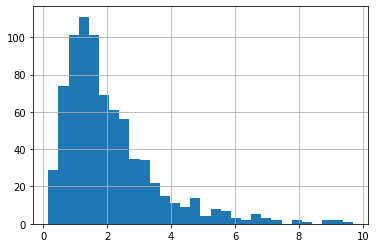

In [13]:
dir_bo_df[dir_bo_df[2020] < 10][2020].hist(bins=30)

In [14]:
dir_bo_df[2020].max()

227.6441

## 2. Get actors' imdb power and bo power

In [15]:
file = "./data/movie_list/metadata_2000-2019.csv"
df = pd.read_csv(file)
with open("./data/movie_list/_excluded_movies.txt", "r") as f:
    excluded_movies = f.read().split('\n')
df = df[~df['Title'].isin(excluded_movies)]
df = df.reset_index(drop=True)
df.loc[:, 'gross_to_budget'] = df.loc[:, 'bo_gross'] / df.loc[:, 'budget']

In [16]:
actor_to_movies = {}
for i in range(df.shape[0]):
    actors = df.loc[i, 'actors'].split(',')
    tt_id = df.loc[i, 'tt_id']
    for actor in actors:
        movies = actor_to_movies.get(actor, [])
        movies.append(tt_id)
        actor_to_movies[actor] = movies
actor_to_movies = {k: v for k, v in sorted(actor_to_movies.items(), key=lambda x: len(x[1]), reverse=True)}

In [17]:
# Print actor who direct most movies:
for i in range(10):
    actor = list(actor_to_movies.keys())[i]
    movies = actor_to_movies[actor]
    print("{}: {}".format(actor, movies))

Dwayne Johnson: ['tt0277296', 'tt0327850', 'tt0351977', 'tt0377471', 'tt0421206', 'tt0492956', 'tt0425061', 'tt1075417', 'tt0762125', 'tt0808510', 'tt1596343', 'tt1397514', 'tt1583421', 'tt1980209', 'tt0882977', 'tt1267297', 'tt2820852', 'tt2126355', 'tt1489889', 'tt4630562', 'tt2283362', 'tt1469304', 'tt2231461', 'tt5758778', 'tt7975244', 'tt6806448', 'tt6513120']
Mark Wahlberg: ['tt0177971', 'tt0133152', 'tt0317740', 'tt0430105', 'tt0407887', 'tt0822854', 'tt0949731', 'tt0467197', 'tt1386588', 'tt1279935', 'tt1637725', 'tt1524137', 'tt1272878', 'tt1980209', 'tt2109248', 'tt2039393', 'tt2637276', 'tt1528854', 'tt1860357', 'tt3371366', 'tt5657846', 'tt5294550', 'tt7401588', 'tt4560436']
Samuel L. Jackson: ['tt0217869', 'tt0162650', 'tt0160797', 'tt0295701', 'tt0264472', 'tt0257076', 'tt0317705', 'tt0121766', 'tt0393162', 'tt0450385', 'tt0489099', 'tt0947802', 'tt0458339', 'tt1860353', 'tt1843866', 'tt2802144', 'tt3460252', 'tt1935859', 'tt3731562', 'tt1959563', 'tt4154664', 'tt6320628'

In [18]:
# Get actors' imdb power:
act_imdb_df = pd.DataFrame(columns=range(2013, 2022))
for actor in actor_to_movies:
    movies = actor_to_movies[actor]
    for year in range(2013, 2022):
        powers = []
        for m in movies:
            if id_to_year(m, df) >= year:
                continue
            powers.append(id_to_score(m, df))
        act_imdb_df.loc[actor, year] = np.nanmean(powers)
act_imdb_df.to_csv("./data/actors_imdb_power.csv")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [19]:
act_imdb_df

,2013,2014,2015,2016,2017,2018,2019,2020,2021
Dwayne Johnson,6.11667,6.13333,6.125,6.17222,6.17895,6.20455,6.18333,6.24444,6.24444
Mark Wahlberg,6.525,6.52857,6.4375,6.41667,6.45263,6.39091,6.41667,6.41667,6.41667
Samuel L. Jackson,6.66154,6.64286,6.71333,6.83529,6.82778,6.82,6.82,6.84783,6.84783
Owen Wilson,6.4,6.3625,6.35294,6.37778,6.265,6.32609,6.32609,6.32609,6.32609
Johnny Depp,6.87333,6.84375,6.81176,6.74737,6.72,6.71429,6.64348,6.64348,6.64348
...,...,...,...,...,...,...,...,...,...
Babou Ceesay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,7.1
Anne Heche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,7.1
Emma Nelson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,6.5
Ron Funches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.1,6.1


In [20]:
# Get actors' bo power:
act_bo_df = pd.DataFrame(columns=range(2013, 2022))
for actor in actor_to_movies:
    movies = actor_to_movies[actor]
    for year in range(2013, 2022):
        powers = []
        for m in movies:
            if id_to_year(m, df) >= year:
                continue
            powers.append(id_to_bo(m, df))
        act_bo_df.loc[actor, year] = np.nanmean(powers)
act_bo_df.to_csv("./data/actors_bo_power.csv")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [21]:
act_bo_df

,2013,2014,2015,2016,2017,2018,2019,2020,2021
Dwayne Johnson,1.42137,1.51862,1.46913,1.48749,1.54335,1.61654,1.53971,1.57203,1.57203
Mark Wahlberg,1.77509,1.74707,1.68593,1.73224,1.67046,1.5613,1.51975,1.51975,1.51975
Samuel L. Jackson,1.86858,1.77904,1.7623,1.72047,1.66895,1.67326,1.67326,1.91852,1.91852
Owen Wilson,1.86208,1.74081,1.69109,1.69073,1.58524,1.73477,1.73477,1.73477,1.73477
Johnny Depp,1.23868,1.18722,1.13093,1.08078,1.0494,1.03515,1.01169,1.01169,1.01169
...,...,...,...,...,...,...,...,...,...
Babou Ceesay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.02056,1.02056
Anne Heche,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.02056,1.02056
Emma Nelson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.459918,0.459918
Ron Funches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30923,1.30923
